## Generating Simulated Deformation Events

Simulated Deformation Events are modeled from a finite rectanglar source using the method from: Okada, Surface deformation due to shear and tensile faults in a half-space.

Okada's Paper:  https://www.bosai.go.jp/e/pdf/Okada_1985_BSSA.pdf <br>
Original Basis: https://github.com/matthew-gaddes/SyInterferoPy

### Imports

In [1]:
if 'NOTEBOOK_INITIATED_FLAG' not in globals():
    NOTEBOOK_INITIATED_FLAG = True
    %cd ..
%pwd

from os import system

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize']=(20,10)

from src.sarsim import gen_simulated_deformation, gen_sim_noise, Okada, gen_gaussian_noise
from src.sarsim import gen_fake_topo, atm_topo_simulate, aps_simulate, coherence_mask_simulate

def display_images(unwrapped, wrapped, masked):
    fig, [axs_unwrapped, axs_wrapped, axs_masked] = plt.subplots(1, 3, sharex=True, sharey=True, tight_layout=True)

    axs_unwrapped.set_title("Unwrapped")
    axs_wrapped.set_title("Wrapped")
    axs_masked.set_title("Mask")

    axs_unwrapped.imshow(unwrapped, cmap='jet')
    axs_wrapped.imshow(wrapped, cmap='jet', vmin=0, vmax=1)
    axs_masked.imshow(masked, cmap='jet')
    
def display_phase(phase, wrapped_phase):
    fig, [axs_wrapped, axs_phase] = plt.subplots(1, 2, sharex=True, sharey=True, tight_layout=True)
    axs_wrapped.set_title("Wrapped")
    axs_wrapped.imshow(wrapped_phase, cmap='jet')
    axs_phase.set_title("True Phase")
    axs_phase.imshow(phase, cmap='jet')

/home/andrew/repos/AI-Event-Monitoring


#### Input Parameters

In [27]:
tile_size  = 512     # img size is (tile_size, tile_size)
event_type = 'quake' # quake, sill, or dyke

source_x = 20000  # min_x, max_x is 0->45000 at (512, 512)
source_y = 20000  # min_y, max_y is 0->45000 at (512, 512)

kwargs = {
    'strike'      : 180,        # for source_type 'quake'
    'dip'         : 45,         # for source_type 'quake'
    'length'      : 2000,       # for source_type 'quake'
    'rake'        : 90,         # for source_type 'quake'
    'slip'        : 5,          # for source_type 'quake'
    'top_depth'   : 4000,       # for source_type 'quake'
    'bottom_depth': 8000,       # for source_type 'quake'
    'width'       : 2000,       # for source_type 'sill' and 'dyke'
    'depth'       : 4000,       # for source_type 'sill' and 'dyke'
    'opening'     : 0.5,        # for source_type 'sill' and 'dyke',
    'source_x'    : source_x,
    'source_y'    : source_y
}

#### Using gen_simulated_deformation with kwargs

The function gen_simulated_deformation does the preceeding process automatically. Including our kwargs will create the event using the specified options. Please note that all of the dict keys need to be present when using kwargs. It is also important to note that there is randomly generated atmospheric noise, using an fft method; thus, if you want the same image every time, you need to use a seed.

__________

quake
__________

Length         (meters)   2000
Top Depth      (meters)   4000
Bottom Depth   (meters)   8000
Depth          (meters)   4000

Slip           (0  or 1)  5
Dip            (degrees)  45
Rake           (degrees)  90
Strike         (degrees)  180
Opening:       (meters)   0.5

Max X Position (meters)   46080
Max Y Position (meters)   46080
Src X Position (meters)   20000
Src Y Position (meters)   20000

Maximum Phase Value:      57.95986172322297

Compute Time   (seconds)  0.12134259501181077
__________



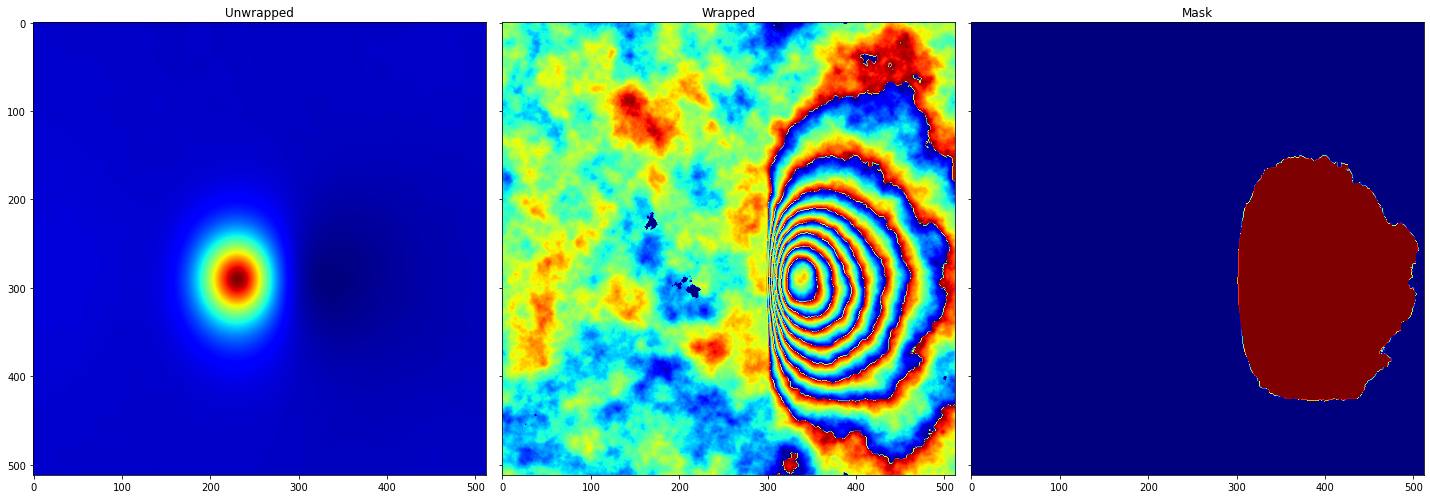

In [28]:
seed       = 0       # 0 seed here means random atmospheric noise every time the function is called.
tile_size  = 512
log        = True
event_type = 'quake'

unwrapped, masked, wrapped, event_is_present = gen_simulated_deformation(
    seed       = seed, 
    tile_size  = tile_size,
    log        = log,
    event_type = event_type,
    **kwargs
)

display_images(unwrapped, wrapped, masked)

#### Using gen_simulated_deformation without kwargs

If no kwargs are provided, the function will randomly generate them within the bounds that have worked best for training purposes. This means that the function will not generate events with all possible valid parameters, at the moment.

__________

quake
__________

Length         (meters)   1966.7420898522435
Top Depth      (meters)   6960.005388349135
Bottom Depth   (meters)   21252.75605316422
Depth          (meters)   1136.5802328093857

Slip           (0  or 1)  1
Dip            (degrees)  45
Rake           (degrees)  -90
Strike         (degrees)  3.6285365351372456
Opening:       (meters)   1

Max X Position (meters)   46080
Max Y Position (meters)   46080
Src X Position (meters)   25811.0
Src Y Position (meters)   6494.0

Maximum Phase Value:      104.23403382339501

Compute Time   (seconds)  0.10963917200569995
__________



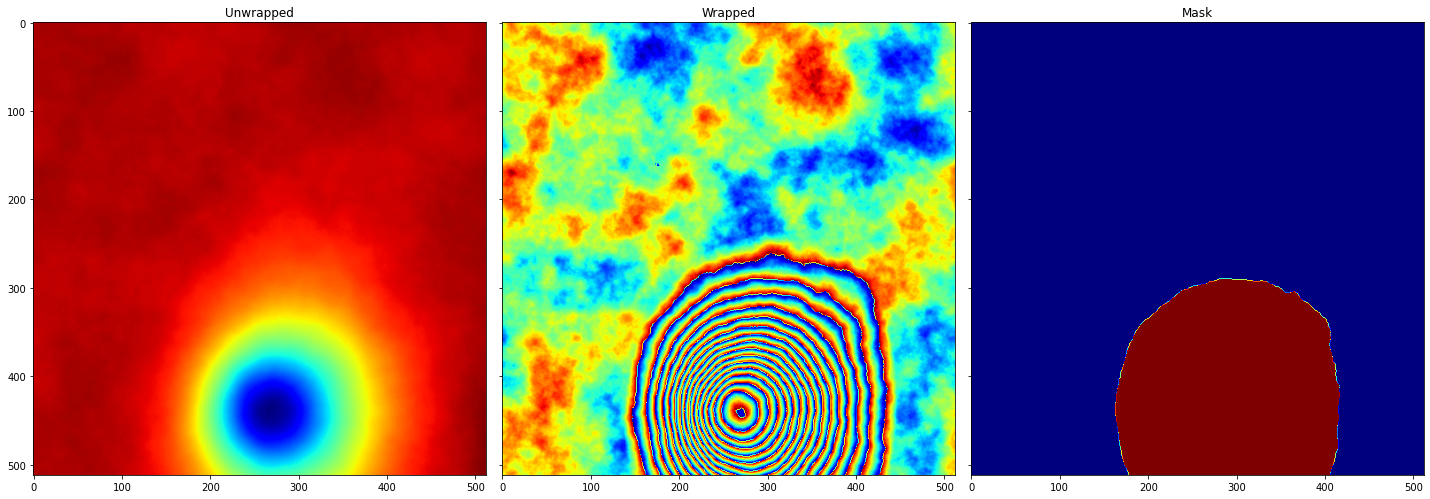

In [4]:
seed       = 0       # 0 seed here means random event paramenters and atmospheric noise
tile_size  = 512
log        = True
event_type = 'quake'

unwrapped, masked, wrapped, event_is_present = gen_simulated_deformation(
    seed       = seed,
    tile_size  = tile_size,
    log        = log,
    event_type = event_type,
)

display_images(unwrapped, wrapped, masked)

#### Generating Simulated Turbulent, Topographic, and Gaussian Noise

Using the gen_sim_noise function, one can generate turbulent atmospheric noise, topographic noise, and gaussian noise tiles. These are currently used as 'negatives' for training purposes. 

Max, Min Noise Values:  23.585030254126497 -11.00195475727802


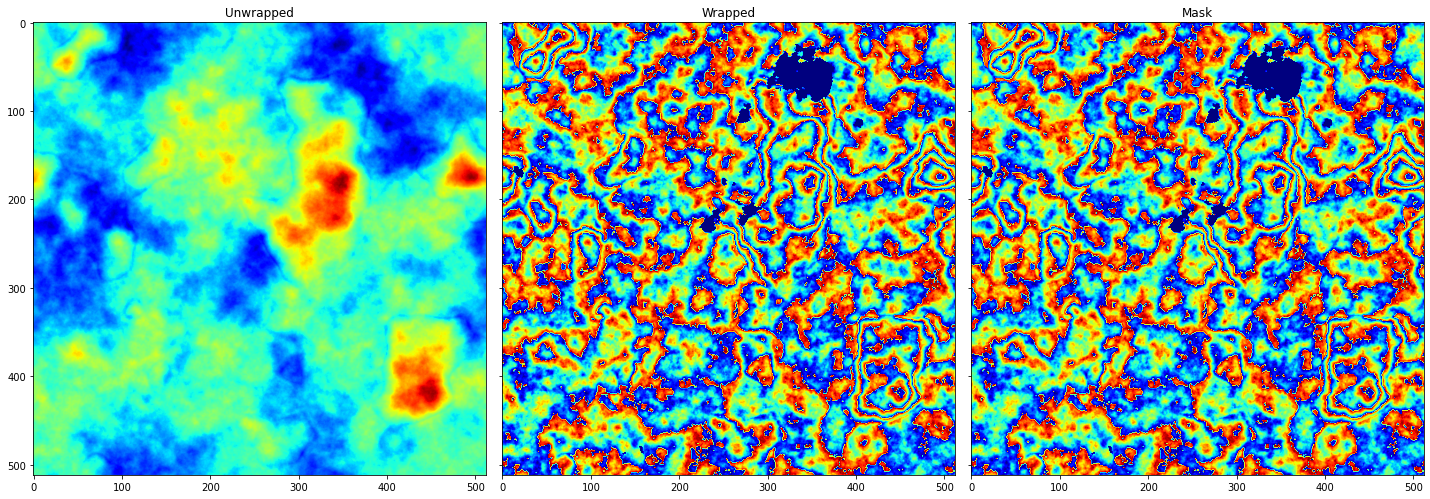

In [5]:
seed              = 0
tile_size         = 512
gaussian_only     = False       # If no atmospheric noise is desired.
atmosphere_scalar = 200 * np.pi # Again, the 'displacement' needs to be scaled.

unwrapped, masked, wrapped, event_is_present = gen_sim_noise(
    seed              = seed,
    tile_size         = tile_size,
    gaussian_only     = False,
    atmosphere_scalar = 200 * np.pi
)

print("Max, Min Noise Values: ", np.max(unwrapped), np.min(unwrapped))

display_images(unwrapped, wrapped, wrapped)

#### Generate Event Manually

If you want to get the actual line-of-sight displacement with no noise or contamination, you can generate a deformation event manually using the Okada class. This requires the basically the same inputs as the gen_simulated_deformation function with kwargs. 

Ultimately, it's purpose is to generate the line-of-sight displacement (self.los_displacement). But it also generates quite of bit of information that you may access:
```python
self.source_type
self.source_x
self.source_y
self.tile_size
self.params
self.x_axis_shape
self.y_axis_shape
self.grid_x
self.grid_y
self.los_vector
self.lames_mu       # μ
self.lames_lambd    # λ
self.nu             # ν (poisson ration)
self.length
self.strike
self.dip            # δ
self.opening
self.slip
self.rake
self.width
self.depth
self.east
self.north
self.okada_x        # ξ
self.okada_y
self.d
self.q
self.eta            # η
self.U1
self.U2
self.U3
self.displacement
self.los_displacement
```

In [6]:
Event = Okada(event_type, (source_x, source_y), tile_size = tile_size, **kwargs)

#### Get Displacement and Amplify

Since the model gives us line-of-sight displacement, the values are generally very low and won't even get close to wrapping around pi. Because of this, we need to scale the values for them to be useful for our purposes.

In [7]:
scalar           = 1000 * np.pi
los_displacement = Event.los_displacement
phase            = scalar * los_displacement
wrapped_phase    = np.angle(np.exp(1j * (phase)))

Max, Min Displacement:  0.05249679703582018 , -0.0037120933592790133
Max, Min Phase:         164.92355190472708 ,  -11.661885226950403


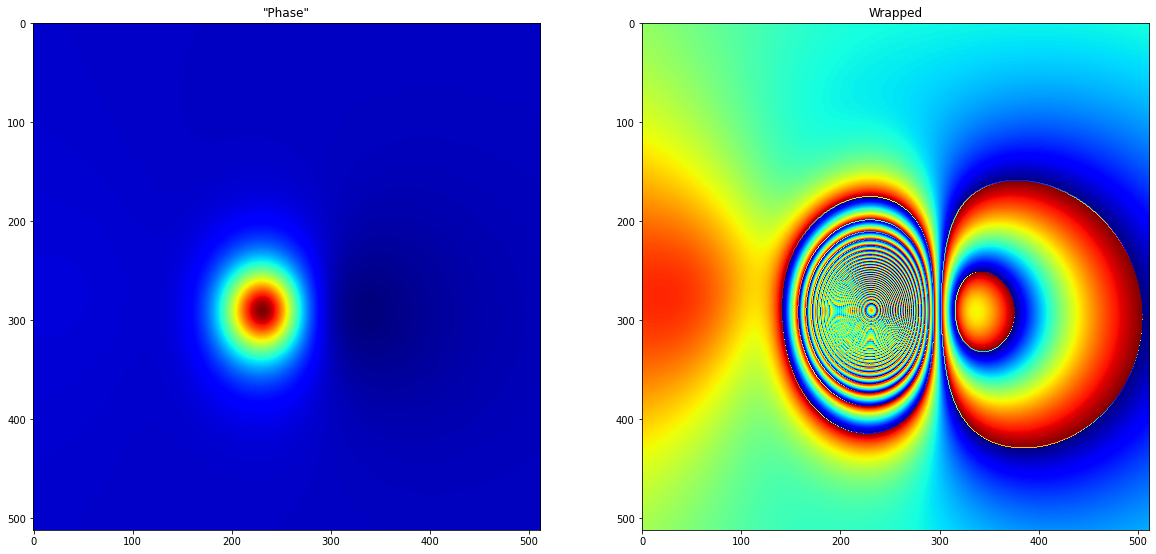

In [8]:
print('Max, Min Displacement: ', np.max(los_displacement), ',', np.min(los_displacement))
print('Max, Min Phase:        ', np.max(phase), ', ', np.min(phase))

fig, [axs_phase, axs_wrapped] = plt.subplots(1, 2)
axs_wrapped.set_title("Wrapped")
axs_wrapped.imshow(wrapped_phase, cmap='jet')
axs_phase.set_title("\"Phase\"")
axs_phase.imshow(phase, cmap='jet')

#### Adding Sources of Noise and Error

##### Error from Turbulent Atmospheres

In [9]:
atmosphere_scalar = 90 * np.pi
turb_phase        = aps_simulate(tile_size) * atmosphere_scalar / 2
phase_with_turb   = phase + turb_phase
wrapped_with_turb = np.angle(np.exp(1j * (phase_with_turb)))

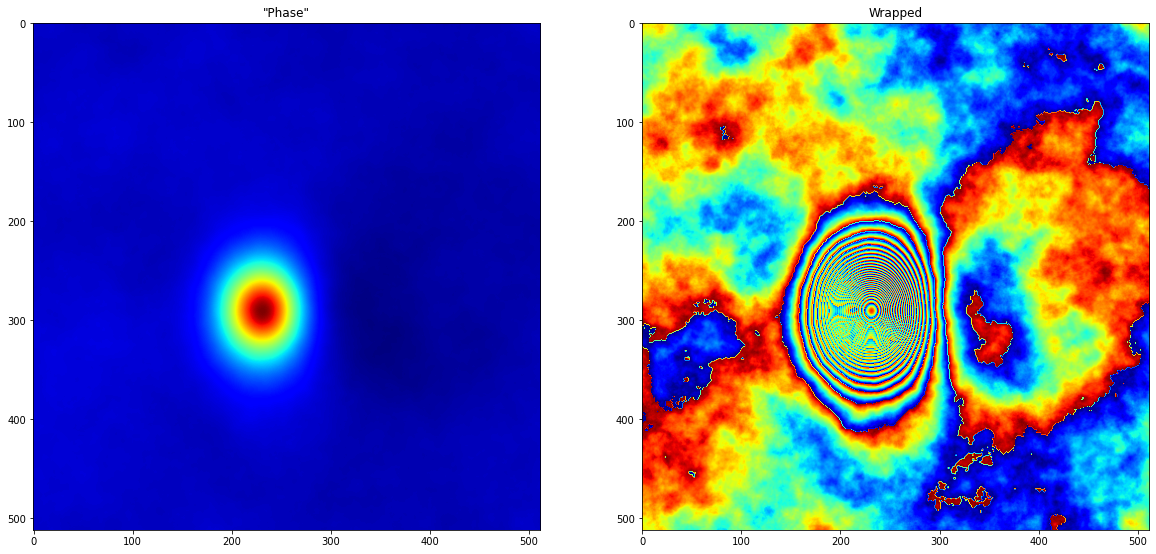

In [10]:
fig, [axs_phase, axs_wrapped] = plt.subplots(1, 2)
axs_wrapped.set_title("Wrapped")
axs_wrapped.imshow(wrapped_with_turb, cmap='jet')
axs_phase.set_title("\"Phase\"")
axs_phase.imshow(phase_with_turb, cmap='jet')

##### Error from Topography

In [11]:
simulated_topography = gen_fake_topo(size = tile_size)
topo_phase           = np.abs(atm_topo_simulate(simulated_topography) * atmosphere_scalar * np.pi)
phase_with_topo      = phase + topo_phase
wrapped_with_topo    = np.angle(np.exp(1j * (phase_with_topo)))

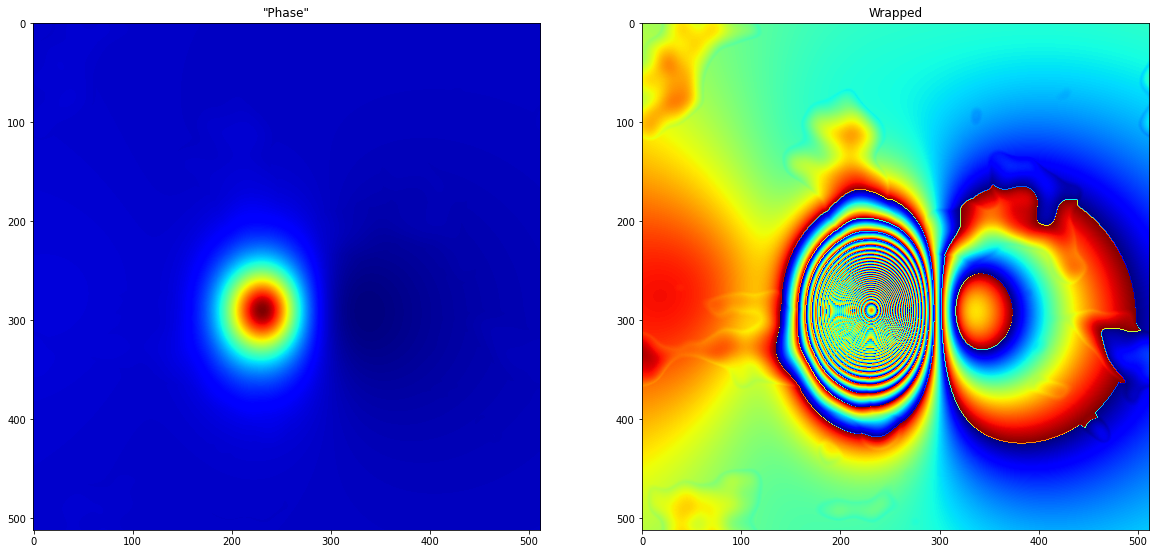

In [12]:
fig, [axs_phase, axs_wrapped] = plt.subplots(1, 2)
axs_wrapped.set_title("Wrapped")
axs_wrapped.imshow(wrapped_with_topo, cmap='jet')
axs_phase.set_title("\"Phase\"")
axs_phase.imshow(phase_with_topo, cmap='jet')

##### Combining Turbulent and Topographic Error

In [13]:
phase_topo_turb   = phase + topo_phase + turb_phase
wrapped_topo_turb = np.angle(np.exp(1j * phase_topo_turb))

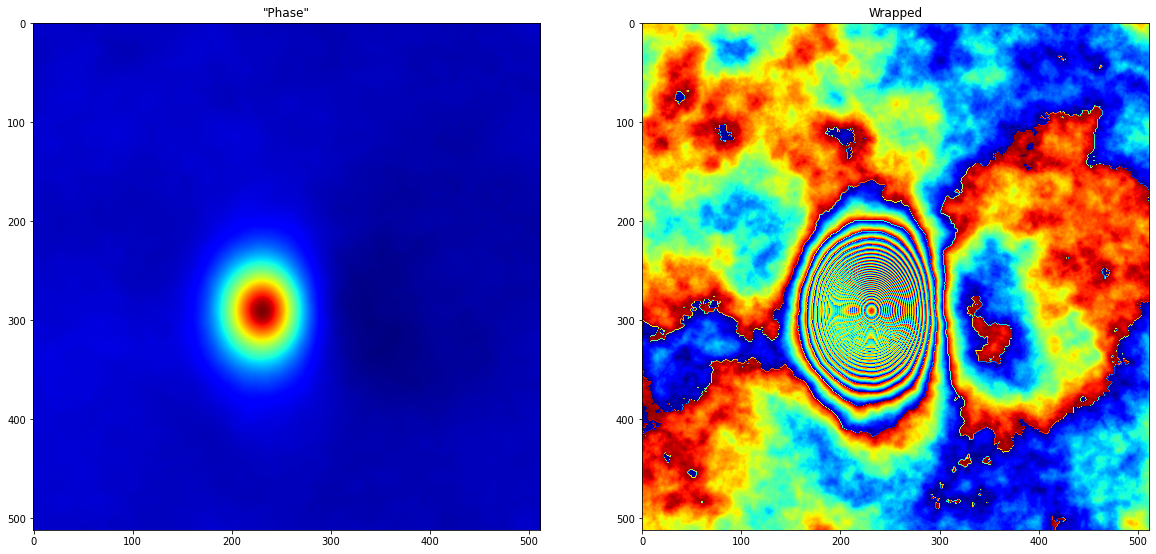

In [14]:
fig, [axs_phase, axs_wrapped] = plt.subplots(1, 2)
axs_wrapped.set_title("Wrapped")
axs_wrapped.imshow(wrapped_topo_turb, cmap='jet')
axs_phase.set_title("\"Phase\"")
axs_phase.imshow(phase_topo_turb, cmap='jet')

##### Gaussian Noise Source

Noise is generated randomly over a gaussian distribution, with noise_level being the maximum possible value of the noise. The threshold allows you to add 'inconsistency' to the noise. This add's random sparsity to the noise, which can be useful for many things such as simulating inconsistency in coherence masks.

In [15]:
noise_level        = 10 * np.pi
noise_threshold    = 10 * np.pi
noise_phase        = gen_gaussian_noise(tile_size, threshold=noise_threshold)
phase_with_noise   = phase_topo_turb + noise_phase
wrapped_with_noise = np.angle(np.exp(1j * phase_with_noise))

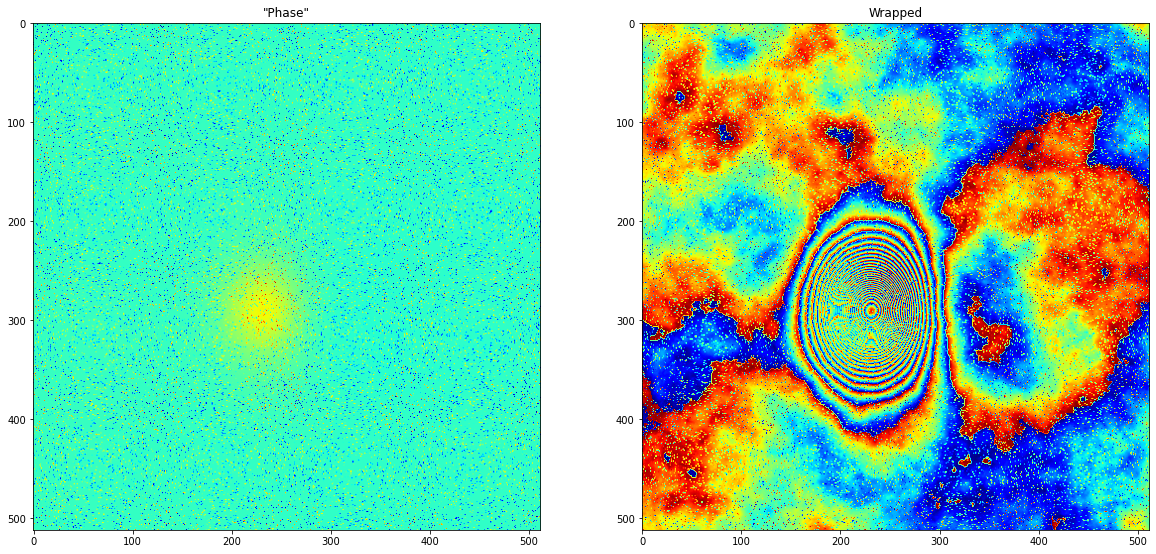

In [16]:
fig, [axs_phase, axs_wrapped] = plt.subplots(1, 2)
axs_wrapped.set_title("Wrapped")
axs_wrapped.imshow(wrapped_with_noise, cmap='jet')
axs_phase.set_title("\"Phase\"")
axs_phase.imshow(phase_with_noise, cmap='jet')

#### Simulated Areas of Low Coherence / General Noise

In [17]:
threshold       = 0.4
coherence_mask  = coherence_mask_simulate(tile_size, threshold=threshold)
coh_indices     = coherence_mask[0, 0:tile_size, 0:tile_size] == 0
phase_with_mask = np.copy(phase_topo_turb)

noise_threshold    = 90 * np.pi
noise_phase        = gen_gaussian_noise(tile_size, threshold=noise_threshold)

phase_with_mask[coh_indices] = noise_phase[coh_indices]

wrapped_with_mask = np.angle(np.exp(1j * phase_with_mask))

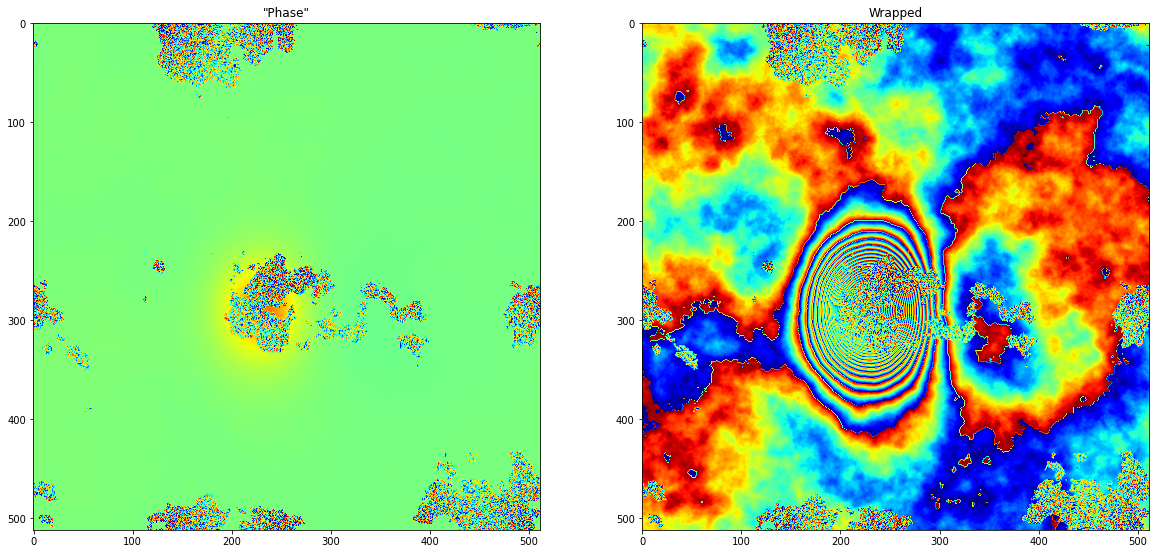

In [18]:
fig, [axs_phase, axs_wrapped] = plt.subplots(1, 2)
axs_wrapped.set_title("Wrapped")
axs_wrapped.imshow(wrapped_with_mask, cmap='jet')
axs_phase.set_title("\"Phase\"")
axs_phase.imshow(phase_with_mask, cmap='jet')

##### Simulated Masked-out Areas of Low Coherence

In [19]:
# This is the same as the above, but with a different coherence mask.
phase_with_mask[coh_indices] = 0

wrapped_with_mask = np.angle(np.exp(1j * phase_with_mask))

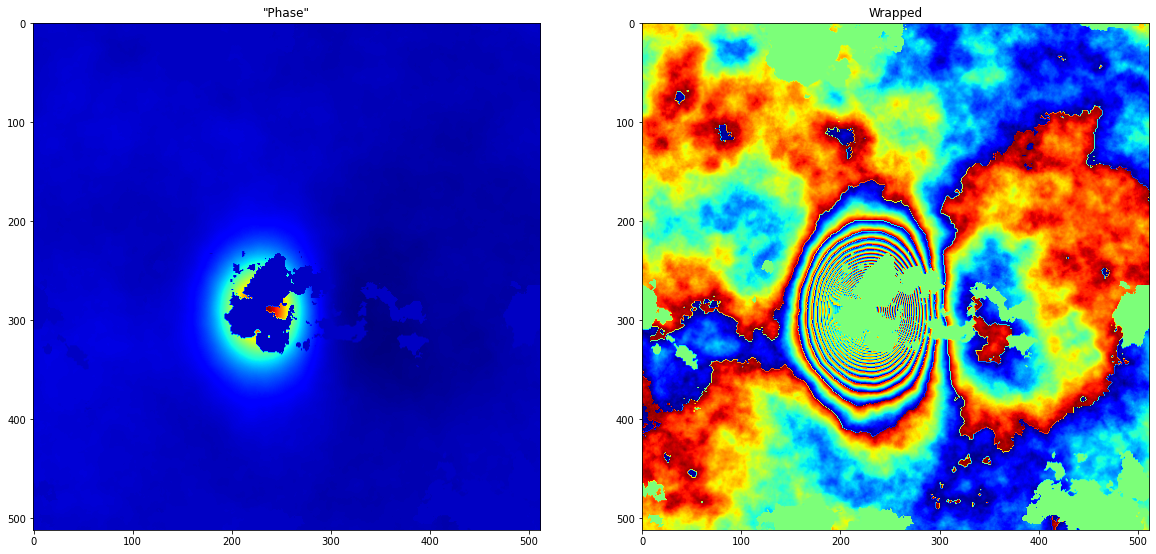

In [20]:
fig, [axs_phase, axs_wrapped] = plt.subplots(1, 2)
axs_wrapped.set_title("Wrapped")
axs_wrapped.imshow(wrapped_with_mask, cmap='jet')
axs_phase.set_title("\"Phase\"")
axs_phase.imshow(phase_with_mask, cmap='jet')

##### Adding Inconsistency to the Coherence Masks

In [21]:
noise_level     = 90 * np.pi
noise_threshold = 10 * np.pi 
noise_phase     = gen_gaussian_noise(tile_size, noise_level=noise_level, threshold=noise_threshold)

wrapped_with_mask = np.angle(np.exp(1j * phase_with_mask))

wrapped_with_mask[coh_indices] = np.angle(np.exp(1j * noise_phase[coh_indices]))

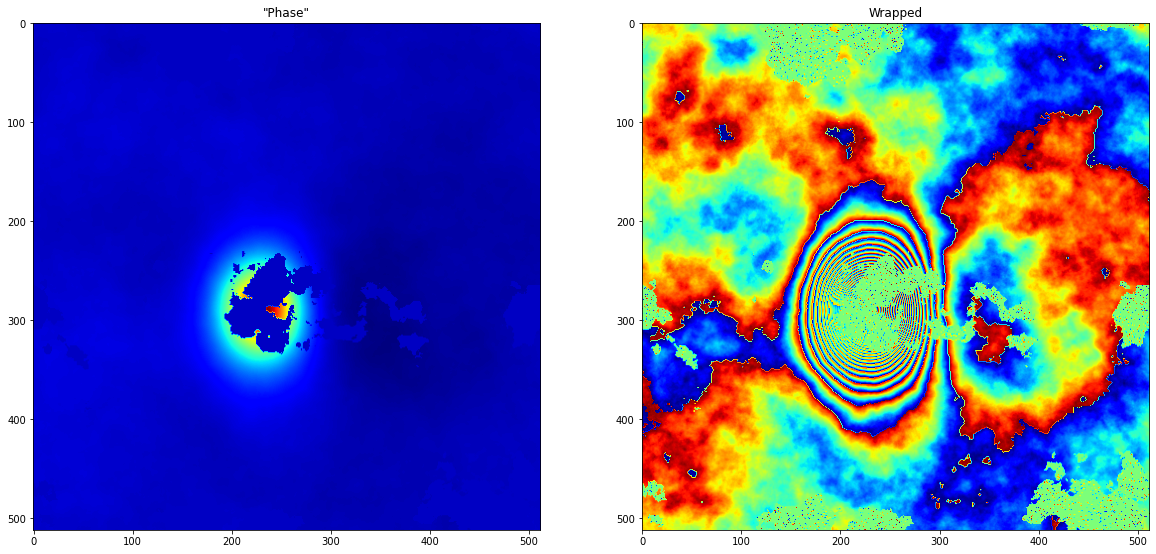

In [22]:
fig, [axs_phase, axs_wrapped] = plt.subplots(1, 2)
axs_wrapped.set_title("Wrapped")
axs_wrapped.imshow(wrapped_with_mask, cmap='jet')
axs_phase.set_title("\"Phase\"")
axs_phase.imshow(phase_with_mask, cmap='jet')

#### Extra: Using Simulated Phase Data with SNAPHU

In [23]:
from array import array

phase_filename   = 'unw_phase_data'
wrapped_filename = 'wrp_phase_data'

phase_file   = open(phase_filename, 'wb')
wrapped_file = open(wrapped_filename, 'wb')

phase_flat   = phase_with_turb.flatten().astype('float32')
wrapped_flat = wrapped_with_turb.flatten().astype('float32')
phase_arr    = array('f', phase_flat)
wrapped_arr  = array('f', wrapped_flat)

phase_arr.tofile(phase_file)
wrapped_arr.tofile(wrapped_file)

phase_file.close()
wrapped_file.close()

In [24]:
system('snaphu -C \"INFILEFORMAT FLOAT_DATA\" -d wrp_phase_data 512')


snaphu v2.0.5
Reading wrapped phase from file wrp_phase_data
No weight file specified.  Assuming uniform weights
No correlation file specified.  Assuming correlation = 0.01
Calculating deformation-mode cost parameters
Initializing flows with MST algorithm
Running nonlinear network flow optimizer
Maximum flow on network: 23
Flow increment: 1  (Total improvements: 0)
Found 1 valid set(s) of connected nodes
Maximum flow on network: 1
Total solution cost: 139388
Integrating phase
Writing output to file snaphu.out
Program snaphu done
Elapsed processor time:   0:00:00.17
Elapsed wall clock time:  0:00:00


0

In [25]:
with open(phase_filename, 'rb') as phase_file:
    phase_data = np.fromfile(phase_file, dtype='float32')
    phase_arr  = np.reshape(phase_arr, (512, 512))

with open(wrapped_filename, 'rb') as wrapped_file:
    wrapped_data = np.fromfile(wrapped_file, dtype='float32')
    wrapped_arr  = np.reshape(wrapped_arr, (512, 512))

with open('snaphu.out', 'rb') as snaphu_file:
    snaphu_data = np.fromfile(snaphu_file, dtype='float32')
    snaphu_arr  = np.reshape(snaphu_data, (512, 2, 512))
    
phase_snaphu_arr = snaphu_arr[:, 1, :]

difference_arr = np.abs(phase_snaphu_arr - phase_arr)

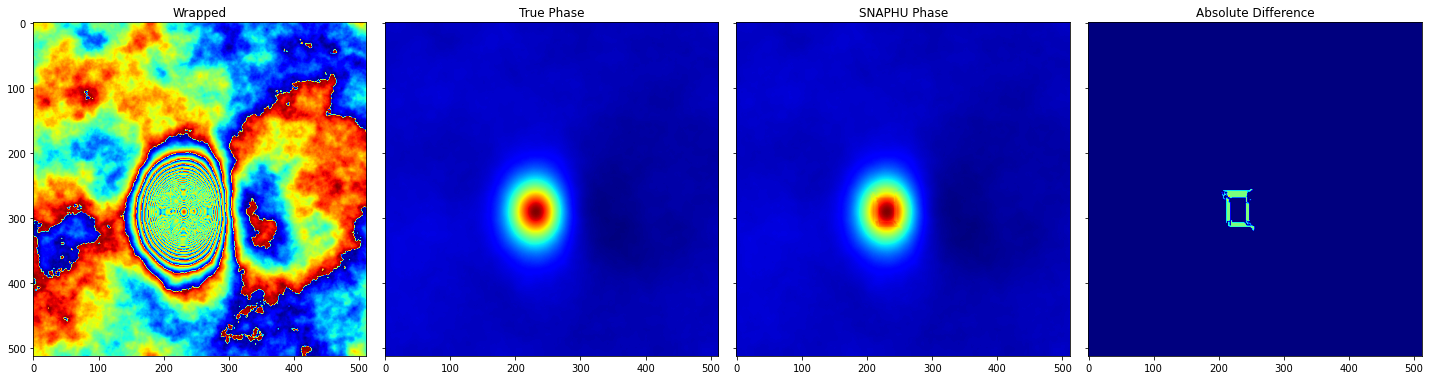

In [26]:
fig, [axs_wrapped, axs_phase, axs_snaphu, axs_diff] = plt.subplots(1, 4, sharex=True, sharey=True, tight_layout=True)
axs_wrapped.set_title("Wrapped")
axs_wrapped.imshow(wrapped_arr, cmap='jet')
axs_phase.set_title("True Phase")
axs_phase.imshow(phase_arr, cmap='jet')
axs_snaphu.set_title("SNAPHU Phase")
axs_snaphu.imshow(phase_snaphu_arr, cmap='jet')
axs_diff.set_title("Absolute Difference")
axs_diff.imshow(difference_arr, cmap='jet')